## Improving Zero-Shot Voice Style Transfer Via Disentangled Representation Learning 

                                                                R. Kaci, L. Salais, A. Wilmet

In [12]:
# /////////////////////////////////////////////////////////////////////////////////////////// <useful libraries> ////

# utils
import os
import numpy as np
from numpy.random import RandomState
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# deep
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio

# signal processing
import soundfile as sf
from scipy import signal

# getting fancy
import IPython.display as ipd
# https://musicinformationretrieval.com/ipython_audio.html

# ////////////////////////////////////////////////////////////////////////////////////////// </useful libraries> ////

### Dataset handling

https://datashare.ed.ac.uk/handle/10283/3443

In [2]:
# //////////////////////////////////////////////////////////////////////////////////////////// <dataset loading> ////

# Each item is a tuple of the form: (waveform, sample_rate, utterance, speaker_id, utterance_id)
vctk_data = torchaudio.datasets.VCTK_092('.',download=True)
loadtrain = DataLoader(vctk_data, batch_size=1, shuffle=True, num_workers=4)

# Train-test splitting
# ...
totalfiles = len(vctk_data)

# /////////////////////////////////////////////////////////////////////////////////////////// </dataset loading> ////

Waveform: tensor([[-0.0671, -0.0682, -0.0674,  ...,  0.0300,  0.0283,  0.0315]])
Sample rate: 48000
p226 saying: Ask her to bring these things with her from the store.  



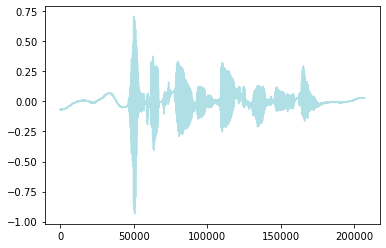

In [3]:
# ///////////////////////////////////////////////////////////////////////////////////////// <data visualisation> ////

n = 232
waveform, sample_rate, utterance, speaker_id, utterance_id = vctk_data[n]
print("Waveform: {}\nSample rate: {}\n{} saying: {}".format(waveform, sample_rate, speaker_id, utterance))
plt.figure()
plt.plot(waveform.t().numpy(),color='powderblue')
plt.show()
ipd.Audio(waveform.numpy(),rate=sample_rate)

# //////////////////////////////////////////////////////////////////////////////////////// </data visualisation> ////

In [13]:
# /////////////////////////////////////////////////////////////////////////////////// <data proeprocessing loop> ////

MELBINS = 80   # 'Slices' in the melspectrogram (see below)

def preprocessVCTK():
    # Audio subsampling (see p. ..)
    sampleMe = torchaudio.transforms.Resample(orig_freq=48000, new_freq=16000)
    # Mel-spectrogram conversion (see p. ..)
    spectreMe = torchaudio.transforms.MelSpectrogram(n_mels=MELBINS, n_fft=1024, win_length=1024, hop_length=256, f_min=90, f_max=7600)

    # Adding a Butterworth high-pass filter and also a norm aux for later on
    b, a = signal.butter(N=5, Wn=30/(0.5*16000), btype='high', analog=False)  
    min_level = np.exp(-100 / 20 * np.log(10))

    # Iterating through the dataset folder
    rootDir = './VCTK-Corpus-0.92/wav48_silence_trimmed'
    targetDir = './VCTK-Corpus-0.92/spmel'
    dirName, subdirList, _ = next(os.walk(rootDir))
    print('Found directory: %s' % dirName)
    for subdir in tqdm(sorted(subdirList)):
        print(subdir)
        if not os.path.exists(os.path.join(targetDir, subdir)):
            os.makedirs(os.path.join(targetDir, subdir))
        _,_, fileList = next(os.walk(os.path.join(dirName,subdir)))
        prng = RandomState(int(subdir[1:])) 
        for fileName in sorted(fileList):
            # Read audio file
            x, fs = sf.read(os.path.join(dirName,subdir,fileName))
            # Remove drifting noise
            y = signal.filtfilt(b, a, x)
            # Add a little random noise for model robustness
            wav = torch.from_numpy(y*0.96 + (prng.rand(y.shape[0])-0.5)*1e-06).float()
            # Compute melspect
            mel = spectreMe(sampleMe(wav))
            D_db = 20 * np.log10(np.maximum(min_level, mel))-16
            S = np.clip((D_db+100)/100, 0, 1)    
            # Save spect    
            np.save(os.path.join(targetDir, subdir, fileName[:-4]), S, allow_pickle=False)
            
preprocessVCTK()
# This would take approx. an hour.
            
# /////////////////////////////////////////////////////////////////////////////////// </data preprocessing loop> ////

Found directory: ./VCTK-Corpus-0.92/wav48_silence_trimmed


p225
p226
p227
p228
p229
p230
p231
p232
p233
p234
p236
p237
p238
p239
p240
p241
p243
p244
p245
p246
p247
p248
p249
p250
p251
p252
p253
p254
p255
p256
p257
p258
p259
p260
p261
p262
p263
p264
p265
p266
p267
p268
p269
p270
p271
p272
p273
p274
p275
p276
p277
p278
p279
p280
p281
p282
p283
p284
p285
p286
p287
p288
p292
p293
p294
p295
p297
p298
p299
p300
p301
p302
p303
p304
p305
p306
p307
p308
p310
p311
p312
p313
p314
p315
p316
p317
p318
p323
p326
p329
p330
p333
p334
p335
p336
p339
p340
p341
p343
p345
p347
p351
p360
p361
p362
p363
p364
p374
p376
s5



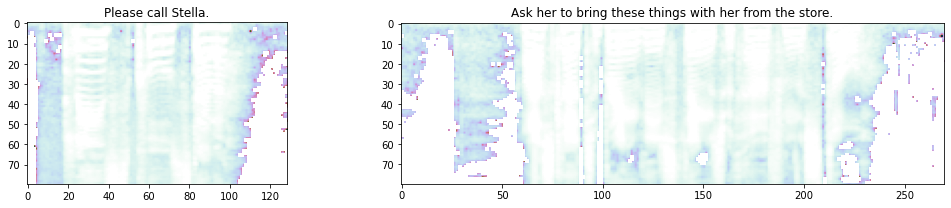

In [5]:
# /////////////////////////////////////////////////////////////////////////////////////////// <mel spectrograms> ////

# Original speaker
mel1 = np.load('./VCTK-Corpus-0.92/spmel/p225/p225_001_mic1..npy')
# New speaker
mel2 = np.load('./VCTK-Corpus-0.92/spmel/p226/p226_002_mic1..npy')
mel1 = torch.from_numpy(mel1)
mel2 = torch.from_numpy(mel2)

spectres = plt.figure(figsize=(15,3))
ax1 = spectres.add_subplot(121)
plt.imshow(mel1.log2().detach().numpy(), cmap='cubehelix')
plt.title("Please call Stella.")
ax2 = spectres.add_subplot(122)
plt.imshow(mel2.log2().detach().numpy(), cmap='cubehelix')
plt.title("Ask her to bring these things with her from the store.")
plt.tight_layout()
plt.show()

# ////////////////////////////////////////////////////////////////////////////////////////// </mel spectrograms> ////

### Model architecture

In [7]:
# ///////////////////////////////////////////////////////////////////////////////////////////////// <parameters> ////

BATCHSZ = 1      # et irl ?.. à voir

EMBSIZE = 256    # Speaker embedding - fixed size
SPKCELL = 768    # LSTM cell size for the speaker encoder

CNVSIZE = 512    # Convolution layers have shape (512, 512)
CTNCELL = 32     # LSTM cell size for the content encoder
DCDCELL = 1024   # LSTM cell size for the decoder

# //////////////////////////////////////////////////////////////////////////////////////////////// </parameters> ////

In [8]:
# ///////////////////////////////////////////////////////////////////////////////////////// <encoding the voice> ////

class SpeakerEncoder(nn.Module):
    def __init__(self):
        super(SpeakerEncoder, self).__init__()
        self.lstm = nn.LSTM(num_layers=2, input_size=MELBINS, batch_first=True, hidden_size=SPKCELL)
        self.fc = nn.Linear(SPKCELL, EMBSIZE) 
        
    def forward(self,inp):
        # batch_size, signal length, features should come last
        inp = inp.transpose(1,2) 
        assert (inp.shape[0] == BATCHSZ and inp.shape[2] == MELBINS)
        # Use the LSTM. Save the last hidden state
        ht = self.lstm(inp)[1][0] 
        assert (ht.shape == (2, BATCHSZ, SPKCELL))
        # Discard the first layer's data.
        ht = ht.view(2,1,BATCHSZ,SPKCELL)[1]
        assert (ht.shape == (1, BATCHSZ, SPKCELL))
        # Projecting the output
        projection = self.fc(ht.squeeze(0))
        assert (projection.shape == (BATCHSZ, EMBSIZE))
        return projection
        
        
class ContentEncoder(nn.Module):
    def __init__(self,freq):
        super(ContentEncoder, self).__init__()
        # This is used for some implicit subsampling.
        self.freq = freq 
        # Three convolutional layers + ReLU activation + batchnorm
        # The content encoder takes a concat. of the mel spectrogram & the speaker embedding as input (see p. ..)
        self.convs = nn.Sequential(
            nn.Conv1d(MELBINS+EMBSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.ReLU(),
            nn.Conv1d(CNVSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.ReLU(),
            nn.Conv1d(CNVSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.ReLU())
        
        self.lstm = nn.LSTM(num_layers=2, input_size=CNVSIZE, batch_first=True, hidden_size=CTNCELL, bidirectional=True)
        
        # for conv in self.convs[::3]:
        # torch.nn.init.xavier_uniform_(self.conv.weight, gain=torch.nn.init.calculate_gain('relu'))
        
    def forward(self,spk,mel):
        length = mel.shape[2]
        # Reporting the speaker embedding on each timestep in the MS
        spk = spk.unsqueeze(-1).expand(-1, -1, length)
        x = torch.cat((mel,spk), dim=1)
        assert (x.shape[0] == BATCHSZ and x.shape[1] == MELBINS+EMBSIZE and x.shape[2] == length)
        # Going through the convolutional net 
        x = self.convs(x).transpose(1, 2)
        assert(x.shape[0] == BATCHSZ and x.shape[1] == length and x.shape[2] == CNVSIZE)
        
        # Feeding the LSTM
        self.lstm.flatten_parameters()
        out, _ = self.lstm(x)
        # out = out.transpose(1, 2)
        # assert (out.shape[0] == BATCHSZ and out.shape[1] == 2 * CTNCELL and out.shape[2] == length)
        # Reminder // it flows both ways.
        fwd = out[:, :, :CTNCELL]
        bwd = out[:, :, CTNCELL:]
        codes = []
        for i in range(0, out.size(1), self.freq):
            codes.append(torch.cat((fwd[:, i + self.freq - 1, :], bwd[:, i, :]), dim=-1))  # pakompri
        return codes
    
# //////////////////////////////////////////////////////////////////////////////////////// </encoding the voice> ////

In [9]:
# /////////////////////////////////////////////////////////////////////////////////////// <converting the voice> ////

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # A convolutional net that takes a target speaker embedding + a source content embedding as input
        # There is no LSTM layer here as in AutoVC
        
        self.convs = nn.Sequential(
            nn.Conv1d(CTNCELL*2+EMBSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.ReLU(),
            nn.Conv1d(CNVSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.ReLU(),
            nn.Conv1d(CNVSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.ReLU())
        self.lstm = nn.LSTM(num_layers=3, input_size=CNVSIZE, batch_first=True, hidden_size=DCDCELL)
        
        # Going back to the initial mel-spectrogram shape.
        self.proj = nn.Conv1d(DCDCELL, MELBINS, kernel_size=1) 
        
        # A post-network that computes the residual signal
        self.postnet = nn.Sequential(
            nn.Conv1d(MELBINS, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.Tanh(),
            nn.Conv1d(CNVSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.Tanh(),
            nn.Conv1d(CNVSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.Tanh(),
            nn.Conv1d(CNVSIZE, CNVSIZE, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(CNVSIZE),
            nn.Tanh(),
            nn.Conv1d(CNVSIZE, MELBINS, kernel_size=5, stride=1, padding=2, dilation=1),
            nn.BatchNorm1d(MELBINS))
    
        # for conv in self.convs[::3]:
        # torch.nn.init.xavier_uniform_(self.conv.weight, gain=torch.nn.init.calculate_gain('relu'))
    
    
    def forward(self,enc):
        assert (enc.shape[0] == BATCHSZ and enc.shape[1] == EMBSIZE+CTNCELL*2)
        
        # Going through the convolutional net 
        x = self.convs(enc).transpose(1, 2)
        # Feeding the LSTM
        self.lstm.flatten_parameters()
        out, _ = self.lstm(x)
        # Projecting the output
        projection = self.proj(out.transpose(1,2))
        assert (projection.shape == (BATCHSZ, MELBINS, enc.shape[2]))
        
        residual = self.postnet(projection)
        return projection, projection+residual
        
# /////////////////////////////////////////////////////////////////////////////////////// <converting the voice> ////

In [10]:
# /////////////////////////////////////////////////////////////////////////////////////// <full generation path> ////

class Compose(nn.Module):
    def __init__(self):
        super(Compose, self).__init__()
        self.spcoder = SpeakerEncoder()
        self.ctcoder = ContentEncoder(16)
        self.decoder = Decoder()
    
    def forward(self,mel1,mel2,cropped=True):
        if cropped:
            mel1 = mel1[:,:,:128]  # temporaire, le temps d'intégrer la classe Dataset
            mel2 = mel2[:,:,:256]  # autre longueur pour s'assurer que ça passe
        # Data from the original speaker
        spk = self.spcoder(mel1)
        # Data from the target content
        ctn = self.ctcoder(spk,mel2)

        # Suitable upsampling + concatenation
        tmp = []
        for code in ctn:
            tmp.append(code.unsqueeze(2).expand(-1,-1,int(mel2.size(2)/len(ctn))))
        cds = torch.cat(tmp, dim=2)
        enc = torch.cat((cds, spk.unsqueeze(2).expand(-1,-1,mel2.size(2))), dim=1)     
        assert (enc.shape[0] == BATCHSZ and enc.shape[1] == EMBSIZE+CTNCELL*2 and enc.shape[2] == mel2.size(2))
        
        # Using the decoder to get a final output + a residual signal
        prj, res = self.decoder(enc)
        return prj, res
    
# ////////////////////////////////////////////////////////////////////////////////////// </full generation path> ////

In [11]:
# Quick test

# Encodeur du speaker > sortie [BATCHSZ,256]
senc = SpeakerEncoder()
spk1 = senc(mel1.unsqueeze(0)[:,:,:128])
spk2 = senc(mel2.unsqueeze(0)[:,:,:256])

# Encodeur du contenu > sortie un peu plus compliquée 
cenc = ContentEncoder(16) 
# C'est ce paramètre ⬆️ freq qui règle le downsampling, et donc nombre de codes en sortie ! 
# AutoVC mettent 16 dans le code, et dans leur article, c'est 32. On reste sur 16 comme dans le nôtre.
ctn1 = cenc(spk1,mel1.unsqueeze(0)[:,:,:128])
ctn2 = cenc(spk2,mel2.unsqueeze(0)[:,:,:256])

# for i in range(len(ctn1)):
#     print("Got {} for code n° {}".format(ctn1[i].shape,i+1))
# for i in range(len(ctn2)):
#     print("Got {} for code n° {}".format(ctn2[i].shape,i+1))

# L'encodeur sort un ensemble de codes.
# Les audios sont ensuite upsamplés, 
# quelle que soit la longueur de la liste de codes, on retrouve l'original.
tmp = []
for code in ctn2:
    tmp.append(code.unsqueeze(2).expand(-1,-1,int(mel2.unsqueeze(0)[:,:,:256].size(2)/len(ctn2))))
cds2 = torch.cat(tmp, dim=2)
enc = torch.cat((cds2, spk1.unsqueeze(2).expand(-1,-1,mel2.unsqueeze(0)[:,:,:256].size(2))), dim=1)

# Le décodeur reconstruit à partir de l'embedding du speaker 1 et du contenu 2.
decd = Decoder()
finl = decd(enc)
assert finl[1].shape == finl[0].shape == mel2.unsqueeze(0)[:,:,:256].shape  
# Projection et résiduel ont bien le même aspect que l'original dit par le speaker 2.
# Pour la loss de reconstruction par rapport à la version du speaker 1 (peut-être dit avec un autre rythme...),
# on devra utiliser un DTW.

# Version automatisée avec la classe Compose :
comp = Compose()
finl = comp(mel1.unsqueeze(0),mel2.unsqueeze(0)) # unsqueeze 0 nécessaires car le batch est mono 